# EDA
## Import necessary libraries 

In [1]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import warnings
import numpy as np
import requests
from io import StringIO
import nfl_data_py as nfl

# Suppress specific FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Load the data from digital ocean

In [2]:
# Define the base path and URLs as per your config file
BASE_CDN_PATH = "https://bigdatabowl2023.nyc3.cdn.digitaloceanspaces.com"
TRACKING_DATA_URL_TEMPLATE = BASE_CDN_PATH + "/raw/tracking_data/tracking_week_{week}.csv"
PLAYS_URL = BASE_CDN_PATH + "/raw/plays.csv"
GAMES_URL = BASE_CDN_PATH + "/raw/games.csv"
PLAYERS_URL = BASE_CDN_PATH + "/raw/players.csv"
COLORS_URL = BASE_CDN_PATH + "/raw/colors.csv"
TACKLES_URL = BASE_CDN_PATH + "/raw/tackles.csv"

# Replace 'week' with the actual week number you want to download
week_number = 1
TRACKING_DATA_URL = TRACKING_DATA_URL_TEMPLATE.format(week=week_number)

# Define a function to download and return a DataFrame
def download_data(url):
    response = requests.get(url)
    if response.status_code == 200:
        # Assuming the data is in CSV format
        return pd.read_csv(StringIO(response.text))
    else:
        print(f"Failed to download data from {url}")
        return None


# Download the data
tracking_data = download_data(TRACKING_DATA_URL)
plays_data = download_data(PLAYS_URL)
players_data = download_data(PLAYERS_URL)
colors_data = download_data(COLORS_URL)
tackles_data = download_data(TACKLES_URL)
games_data = download_data(GAMES_URL) 

In [3]:
print(tracking_data.info())
print(plays_data.info())
print(players_data.info())
print(colors_data.info())
print(tackles_data.info())
print(games_data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1407439 entries, 0 to 1407438
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   gameId         1407439 non-null  int64  
 1   playId         1407439 non-null  int64  
 2   nflId          1346246 non-null  float64
 3   displayName    1407439 non-null  object 
 4   frameId        1407439 non-null  int64  
 5   time           1407439 non-null  object 
 6   jerseyNumber   1346246 non-null  float64
 7   club           1407439 non-null  object 
 8   playDirection  1407439 non-null  object 
 9   x              1407439 non-null  float64
 10  y              1407439 non-null  float64
 11  s              1407439 non-null  float64
 12  a              1407439 non-null  float64
 13  dis            1407439 non-null  float64
 14  o              1346397 non-null  float64
 15  dir            1346397 non-null  float64
 16  event          130268 non-null   object 
dtypes: float

## Load DATA from pipeline

In [4]:
df = pd.read_csv('/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_1_completions_only_run2.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Loop through weeks 2 to 9
for week in range(1, 10):
    # Construct file path for the current week
    file_path = f'/Users/nick/nfl-big-data-bowl-2024/data/final_pso_pipeline_results_week_{week}_completions_only_run2.csv'
    
    # Read the data
    week_df = pd.read_csv(file_path)
    
    # Remove any unnamed columns
    week_df = week_df.loc[:, ~week_df.columns.str.contains('^Unnamed')]
    
    # Append to the original DataFrame
    df = pd.concat([df, week_df], ignore_index=True)


In [5]:
df.columns

Index(['nflId', 'frechet_distance', 'play_id', 'game_id', 'week_num',
       'displayName', 'position', 'gameId', 'playId', 'passResult',
       'expectedPointsAdded', 'defensiveTeam'],
      dtype='object')

In [6]:
#sanity check
plays_per_game = df.groupby('game_id')['play_id'].nunique()

# Calculating the average number of plays per game
average_plays_per_game = plays_per_game.mean()
average_plays_per_game

41.4921875

20 per team seems reasonable 

In [7]:
# Merge the DataFrames on 'playId' and 'nflId'
frechet_tackles_df = pd.merge(df, tackles_data, left_on=['playId', 'nflId','gameId'], right_on=['playId', 'nflId','gameId'], how='left')

In [8]:
frechet_tackles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29575 entries, 0 to 29574
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   nflId                29575 non-null  float64
 1   frechet_distance     29575 non-null  float64
 2   play_id              29575 non-null  int64  
 3   game_id              29575 non-null  int64  
 4   week_num             29575 non-null  int64  
 5   displayName          29575 non-null  object 
 6   position             29575 non-null  object 
 7   gameId               29575 non-null  int64  
 8   playId               29575 non-null  int64  
 9   passResult           29458 non-null  object 
 10  expectedPointsAdded  29575 non-null  float64
 11  defensiveTeam        29575 non-null  object 
 12  tackle               4811 non-null   float64
 13  assist               4811 non-null   float64
 14  forcedFumble         4811 non-null   float64
 15  pff_missedTackle     4811 non-null  

In [9]:
import pandas as pd

# Assuming df is your DataFrame
# Fill NaN values in defensive stats with 0
frechet_tackles_df[['tackle', 'assist', 'forcedFumble']] = frechet_tackles_df[['tackle', 'assist', 'forcedFumble']].fillna(0)

# Selecting non-ID and defensive stats columns
columns_of_interest = ['frechet_distance', 'expectedPointsAdded', 'tackle', 'assist', 'forcedFumble']

# Calculate correlation
correlation_matrix = frechet_tackles_df[columns_of_interest].corr()

print(correlation_matrix)


                     frechet_distance  expectedPointsAdded    tackle  \
frechet_distance             1.000000             0.181870  0.000479   
expectedPointsAdded          0.181870             1.000000  0.025801   
tackle                       0.000479             0.025801  1.000000   
assist                      -0.026442            -0.008502 -0.062759   
forcedFumble                -0.010130            -0.063358  0.091151   

                       assist  forcedFumble  
frechet_distance    -0.026442     -0.010130  
expectedPointsAdded -0.008502     -0.063358  
tackle              -0.062759      0.091151  
assist               1.000000      0.019878  
forcedFumble         0.019878      1.000000  


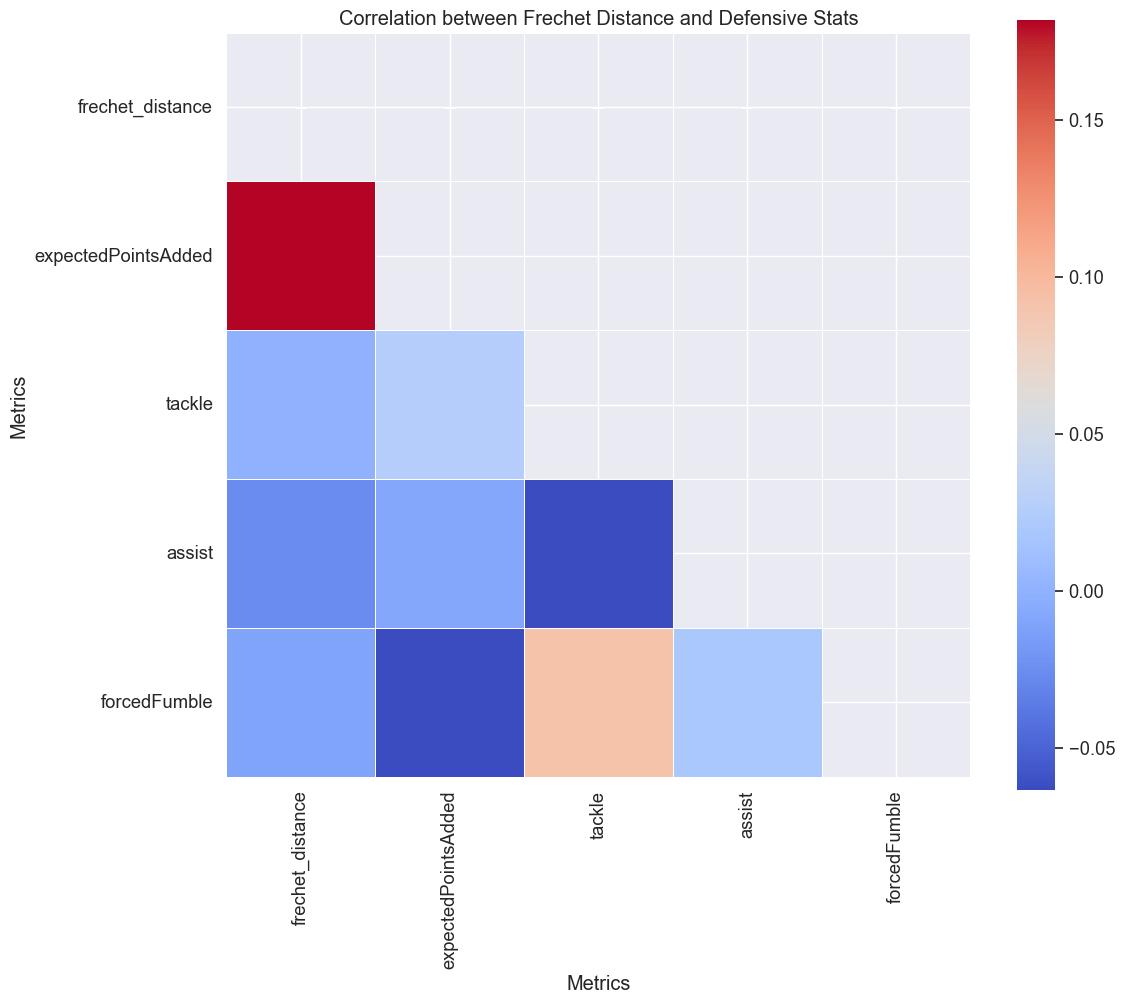

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming 'frechet_tackles_df' is a predefined DataFrame with relevant data
# Make sure to replace the sample data creation with your actual DataFrame

# Fill NaN values with 0 in the DataFrame
frechet_tackles_df[['tackle', 'assist', 'forcedFumble']] = frechet_tackles_df[['tackle', 'assist', 'forcedFumble']].fillna(0)

# Selecting the columns of interest
columns_of_interest = ['frechet_distance', 'expectedPointsAdded', 'tackle', 'assist', 'forcedFumble']

# Calculate the correlation matrix
correlation_matrix = frechet_tackles_df[columns_of_interest].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Increase the figure size and adjust font scale for better visibility
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.2)

# Create a heatmap with a mask for the upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, square=True)

# Adding titles and labels for clarity
plt.title('Correlation between Frechet Distance and Defensive Stats')
plt.xlabel('Metrics')
plt.ylabel('Metrics')

# Show the plot
plt.show()


In [11]:
merged_df.info()

NameError: name 'merged_df' is not defined

High correlation here because the players are traviling farther and farther away from the frechet distance when a secondary player makes a tackle. 

In [ ]:
df

In [ ]:
# Define the years and columns of interest
years = [2022]
columns = ['old_game_id', 'play_id', 'yards_after_catch', 
           'xyac_epa', 'xyac_mean_yardage', 'xyac_median_yardage', 
           'comp_yac_epa', 'comp_yac_wpa', 'week']

# Import the play-by-play data
pbp_data = nfl.import_pbp_data(years, columns)

# Filter for weeks 1-9
filtered_pbp_data = pbp_data[pbp_data['week'].between(1, 10)]

# Ensure the data types for merging columns are consistent
filtered_pbp_data['old_game_id'] = filtered_pbp_data['old_game_id'].astype(int)
team_level_agg_per_play['gameId'] = team_level_agg_per_play['gameId'].astype(int)

# Import the play_level_frechet data
# You would need to specify how to import this data, as the method is not provided in your query

# Merge the data
data = pd.merge(filtered_pbp_data, df, left_on=['old_game_id', 'play_id'], right_on=['gameId', 'play_id'])


In [ ]:
data.columns

In [ ]:
import pandas as pd

# Assuming df is your DataFrame containing the dataset.

# Filter for plays by defensive team 'SF'
df_sf = data[data['defensiveTeam'] == 'SF']

high_xyac = df_sf.nlargest(10, 'xyac_mean_yardage')[['week_num', 'game_id', 'play_id']]
low_xyac = df_sf.nsmallest(10, 'xyac_mean_yardage')[['week_num', 'game_id', 'play_id']]
high_yac = df_sf.nlargest(10, 'yards_after_catch')[['week_num', 'game_id', 'play_id']]
low_yac = df_sf.nsmallest(10, 'yards_after_catch')[['week_num', 'game_id', 'play_id']]
high_frechet = df_sf.nlargest(10, 'frechet_distance')[['week_num', 'game_id', 'play_id']]
low_frechet = df_sf.nsmallest(10, 'frechet_distance')[['week_num', 'game_id', 'play_id']]
high_air_yards = df_sf.nlargest(10, 'ngs_air_yards')[['week_num', 'game_id', 'play_id']]
low_air_yards = df_sf.nsmallest(10, 'ngs_air_yards')[['week_num', 'game_id', 'play_id']]

# Combine and remove duplicates
specific_plays = pd.concat([high_xyac, low_xyac, high_yac, low_yac, high_frechet, low_frechet, high_air_yards, low_air_yards]
                          ).drop_duplicates(subset=['week_num', 'game_id', 'play_id']).to_dict('records')

# Display the selected plays
specific_plays



In [ ]:
# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
data['yac_diff'] =  data['xyac_mean_yardage'] - data['yards_after_catch']

In [ ]:
# Aggregate at the team level to get averages across all plays per team
team_level_agg_per_play = data.groupby(['defensiveTeam','playId']).agg(
    average_frechet_per_player=('frechet_distance', 'mean'),
    total_frechet_all_player = ('frechet_distance', 'sum'),
    number_in_swarm = ('nflId', 'nunique'), 
    gameId = ('gameId' , 'first'),
    yac_diff = ('yac_diff','first'), 
    yac = ('yards_after_catch','first'),
    comp_yac_epa = ('comp_yac_epa','first')
).reset_index()


In [ ]:
team_level_agg_per_play['number_in_swarm'].value_counts()

In [ ]:
# Filter out plays with only one unique player
team_level_agg_per_play = team_level_agg_per_play[ team_level_agg_per_play['number_in_swarm'] > 1]

In [ ]:
team_level_agg_per_play

In [ ]:
# Aggregate at the player level to get averages across all plaue
team_level_agg = team_level_agg_per_play.groupby('defensiveTeam').agg(
    total_frechet=('average_frechet_per_player', 'sum'),
    average_frechet = ('average_frechet_per_player', 'mean'),
    average_in_swarm = ('number_in_swarm', 'mean'), 
    average_yac_diff = ('yac_diff', 'mean'),
    total_yac_diff = ('yac_diff','sum'), 
    average_yac = ('yac', 'mean'),
    total_yac = ('yac','mean'),
    average_comp_yac_epa = ('comp_yac_epa', 'mean'),
    total_comp_yac_epa = ('comp_yac_epa','sum')
).reset_index()

In [ ]:
data.columns

In [12]:
# Aggregate at the player level to get averages across all plaue
player_level_agg = data.groupby(['nflId','displayName','position','defensiveTeam']).agg(
    total_frechet=('frechet_distance', 'sum'),
    average_frechet = ('frechet_distance', 'mean'),
    average_yac_diff = ('yac_diff', 'mean'),
    total_yac_diff = ('yac_diff','sum'), 
    average_yac = ('yards_after_catch', 'mean'),
    total_yac = ('yards_after_catch','mean'),
    average_comp_yac_epa = ('comp_yac_epa', 'mean'),
    total_comp_yac_epa = ('comp_yac_epa','sum'),
    number_of_plays = ('playId','nunique'),
    number_of_games= ('gameId','nunique')

).reset_index()

NameError: name 'data' is not defined

In [475]:
player_level_agg = player_level_agg[player_level_agg['number_of_plays'] > 20]

# Assuming completed_passes is your DataFrame
player_level_agg['pasta_index'] = (player_level_agg['average_yac_diff'] / player_level_agg['average_frechet'] )*100
team_level_agg['pasta_index'] = (team_level_agg['average_yac_diff'] / team_level_agg['average_frechet'] )*100


In [476]:
player_level_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 242 entries, 0 to 322
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   nflId                 242 non-null    float64
 1   displayName           242 non-null    object 
 2   position              242 non-null    object 
 3   defensiveTeam         242 non-null    object 
 4   total_frechet         242 non-null    float64
 5   average_frechet       242 non-null    float64
 6   average_yac_diff      242 non-null    float32
 7   total_yac_diff        242 non-null    float32
 8   average_yac           242 non-null    float32
 9   total_yac             242 non-null    float32
 10  average_comp_yac_epa  242 non-null    float32
 11  total_comp_yac_epa    242 non-null    float32
 12  number_of_plays       242 non-null    int64  
 13  number_of_games       242 non-null    int64  
 14  pasta_index           242 non-null    float64
dtypes: float32(6), float64(4), i

In [477]:
# Merge the aggregated data with the team colors data
team_df_with_colors = team_level_agg.merge(colors_data, left_on='defensiveTeam', right_on='team_abbr')
player_df_with_colors = player_level_agg.merge(colors_data, left_on='defensiveTeam', right_on='team_abbr')


In [478]:
team_df_with_colors.columns

Index(['defensiveTeam', 'total_frechet', 'average_frechet', 'average_in_swarm',
       'average_yac_diff', 'total_yac_diff', 'average_yac', 'total_yac',
       'average_comp_yac_epa', 'total_comp_yac_epa', 'pasta_index',
       'team_abbr', 'team_name', 'team_id', 'team_nick', 'team_conf',
       'team_division', 'team_color', 'team_color2', 'team_color3',
       'team_color4', 'team_logo_wikipedia', 'team_logo_espn', 'team_wordmark',
       'team_conference_logo', 'team_league_logo'],
      dtype='object')

In [479]:
# Save the DataFrame as a CSV file
team_df_with_colors.to_csv('team_level_filtered_completed_passes.csv', index=False)
player_df_with_colors.to_csv('player_level_filtered_completed_passes.csv', index=False)


In [480]:
import pandas as pd


# Calculate average PASTA score, YAC diff, and average Frechet distance for each team
player_totals = player_df_with_colors[['displayName','defensiveTeam','team_wordmark','team_logo_espn','pasta_index', 'average_yac_diff','average_frechet', 'total_yac','average_yac','average_comp_yac_epa']]


# Sort by PASTA score and reset the index to keep defensiveTeam as a column
player_totals_scores = player_df_with_colors.sort_values(by='pasta_index', ascending=False).reset_index()

# Add PASTA rank
player_totals_scores['PASTA RANK'] = player_totals_scores['pasta_index'].rank(method='dense', ascending=False)

# Round all numerical columns to one decimal place
player_totals_scores = player_totals_scores.round(1)

# Optional: Drop the original index column if it's still there
if 'index' in player_totals_scores.columns:
    player_totals_scores.drop(columns=['index'], inplace=True)



In [481]:
import pandas as pd
playfrechet_team_df_with_colors = team_df_with_colors
# Assuming completed_passes is your DataFrame
playfrechet_team_df_with_colors['pasta_index'] = (playfrechet_team_df_with_colors['average_yac_diff'] / playfrechet_team_df_with_colors['average_frechet'] )*100

# Calculate average PASTA score, YAC diff, and average Frechet distance for each team
team_totals = playfrechet_team_df_with_colors[['defensiveTeam','team_wordmark','team_logo_espn','pasta_index', 'average_yac_diff','average_frechet','average_in_swarm', 'total_yac','average_yac','average_comp_yac_epa']]


# Sort by PASTA score and reset the index to keep defensiveTeam as a column
team_pasta_scores = team_totals.sort_values(by='pasta_index', ascending=False).reset_index()

# Add PASTA rank
team_pasta_scores['PASTA RANK'] = team_pasta_scores['pasta_index'].rank(method='dense', ascending=False)

# Round all numerical columns to one decimal place
team_pasta_scores = team_pasta_scores.round(1)

# Optional: Drop the original index column if it's still there
if 'index' in team_pasta_scores.columns:
    team_pasta_scores.drop(columns=['index'], inplace=True)




In [482]:
player_pasta_rankings.columns

Index(['PASTA RANK', 'displayName', 'position', 'team_wordmark', 'pasta_index',
       'average_yac_diff', 'average_frechet', 'average_comp_yac_epa',
       'number_of_plays', 'inverted_epa'],
      dtype='object')

In [483]:
# Assuming team_pasta_scores is your DataFrame
columns_of_interest = ['PASTA RANK','team_wordmark', 'pasta_index','average_yac_diff', 'average_frechet', 'average_comp_yac_epa', 'average_in_swarm']
team_pasta_rankings = team_pasta_scores[columns_of_interest]


# Assuming team_pasta_scores is your DataFrame
columns_of_interest = ['PASTA RANK','displayName','position','team_wordmark', 'pasta_index','average_yac_diff', 'average_frechet', 'average_comp_yac_epa','number_of_plays']
player_pasta_rankings = player_totals_scores[columns_of_interest]


In [484]:
from IPython.display import display, HTML

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Create a copy of the DataFrame for display
display_df = team_pasta_scores.copy()

# Apply the image formatter
display_df['team_wordmark'] = display_df['team_wordmark'].map(image_formatter)

# Convert DataFrame to HTML and display
display(HTML(display_df.to_html(escape=False)))


,defensiveTeam,team_wordmark,team_logo_espn,pasta_index,average_yac_diff,average_frechet,average_in_swarm,total_yac,average_yac,average_comp_yac_epa,PASTA RANK
0,DEN,,https://a.espncdn.com/i/teamlogos/nfl/500/den.png,18.2,1.3,7.0,5.0,4.4,4.4,0.5,1.0
1,TEN,,https://a.espncdn.com/i/teamlogos/nfl/500/ten.png,14.7,0.9,6.1,5.3,4.7,4.7,0.6,2.0
2,TB,,https://a.espncdn.com/i/teamlogos/nfl/500/tb.png,12.0,0.8,6.7,4.8,4.7,4.7,0.6,3.0
3,NYJ,,https://a.espncdn.com/i/teamlogos/nfl/500/nyj.png,10.6,0.8,7.1,4.9,4.8,4.8,0.6,4.0
4,LAC,,https://a.espncdn.com/i/teamlogos/nfl/500/lac.png,9.8,0.7,7.4,4.9,4.9,4.9,0.7,5.0
5,PHI,,https://a.espncdn.com/i/teamlogos/nfl/500/phi.png,9.3,0.7,7.0,5.0,5.1,5.1,0.8,6.0
6,LA,,https://a.espncdn.com/i/teamlogos/nfl/500/lar.png,9.1,0.6,6.8,5.1,4.8,4.8,0.7,7.0
7,CAR,,https://a.espncdn.com/i/teamlogos/nfl/500-dark/car.png,9.1,0.6,7.2,4.9,4.7,4.7,0.6,8.0
8,BUF,,https://a.espncdn.com/i/teamlogos/nfl/500/buf.png,8.1,0.6,7.2,5.1,4.9,4.9,0.6,9.0
9,SF,,https://a.espncdn.com/i/teamlogos/nfl/500/sf.png,5.3,0.4,7.4,4.8,5.8,5.8,0.7,10.0


In [485]:
from IPython.display import display, HTML

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Create a copy of the DataFrame for display
display_df = player_pasta_rankings.copy()

# Apply the image formatter
display_df['team_wordmark'] = display_df['team_wordmark'].map(image_formatter)

# Convert DataFrame to HTML and display
display(HTML(display_df.to_html(escape=False)))

,PASTA RANK,displayName,position,team_wordmark,pasta_index,average_yac_diff,average_frechet,average_comp_yac_epa,number_of_plays
0,1.0,Daron Bland,CB,,36.3,2.1,5.7,0.4,36
1,2.0,Jeremy Chinn,FS,,33.1,2.0,6.0,0.4,67
2,3.0,Justin Simmons,FS,,28.8,1.9,6.5,0.5,96
3,4.0,Logan Ryan,FS,,27.8,1.5,5.3,0.5,61
4,5.0,J.C. Jackson,CB,,26.4,1.7,6.5,0.7,78
5,6.0,Damarri Mathis,CB,,25.0,1.9,7.5,0.5,102
6,7.0,Micah Hyde,FS,,24.6,1.3,5.2,0.8,40
7,8.0,Terrell Burgess,FS,,22.4,1.3,5.7,0.5,24
8,9.0,Lonnie Johnson,CB,,22.4,1.3,6.0,0.6,26
9,10.0,Kareem Jackson,SS,,22.1,1.4,6.1,0.5,177


In [486]:
# Assuming 'player_pasta_rankings' is a predefined DataFrame with relevant data
# Sort the DataFrame based on 'PASTA RANK'
player_pasta_rankings = player_pasta_rankings.sort_values('PASTA RANK', ascending=True)

# We'll now group by 'position' and take the top 5 from each position
top_players_by_position = player_pasta_rankings.groupby('position').head(5)

# Function to get the HTML representation of an image
def image_formatter(im):
    return f'<img src="{im}" width="100">'

# Apply the image formatter
top_players_by_position.loc[:, 'team_wordmark'] = top_players_by_position['team_wordmark'].apply(image_formatter)

# Display the DataFrame with styles
styles = [
    dict(selector="th", props=[("font-size", "110%"), ("text-align", "center")]),
    dict(selector="td", props=[("text-align", "center")]),
    dict(selector="caption", props=[("caption-side", "bottom")])
]

html = (top_players_by_position.style
    .background_gradient(subset=['average_frechet'], cmap='coolwarm')
    .background_gradient(subset=['average_yac_diff'], cmap='coolwarm')
    .set_table_styles(styles)
    .set_caption("Top 5 Players at Each Position Ranked by PASTA RANK")
    .to_html(escape=False)) # using to_html instead of render

# Display styled DataFrame side by side for each position
display(HTML(html))



,PASTA RANK,displayName,position,team_wordmark,pasta_index,average_yac_diff,average_frechet,average_comp_yac_epa,number_of_plays
0,1.000000,Daron Bland,CB,,36.300000,2.100000,5.700000,0.400000,36
1,2.000000,Jeremy Chinn,FS,,33.100000,2.000000,6.000000,0.400000,67
2,3.000000,Justin Simmons,FS,,28.800000,1.900000,6.500000,0.500000,96
3,4.000000,Logan Ryan,FS,,27.800000,1.500000,5.300000,0.500000,61
4,5.000000,J.C. Jackson,CB,,26.400000,1.700000,6.500000,0.700000,78
5,6.000000,Damarri Mathis,CB,,25.000000,1.900000,7.500000,0.500000,102
6,7.000000,Micah Hyde,FS,,24.600000,1.300000,5.200000,0.800000,40
7,8.000000,Terrell Burgess,FS,,22.400000,1.300000,5.700000,0.500000,24
8,9.000000,Lonnie Johnson,CB,,22.400000,1.300000,6.000000,0.600000,26
9,10.000000,Kareem Jackson,SS,,22.100000,1.400000,6.100000,0.500000,177


In [487]:
team_pasta_scores.columns

Index(['defensiveTeam', 'team_wordmark', 'team_logo_espn', 'pasta_index',
       'average_yac_diff', 'average_frechet', 'average_in_swarm', 'total_yac',
       'average_yac', 'average_comp_yac_epa', 'PASTA RANK'],
      dtype='object')

need tp adjust and modify everything below here 

In [488]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(team_pasta_scores['average_yac_diff'], team_pasta_scores['pasta_index'])


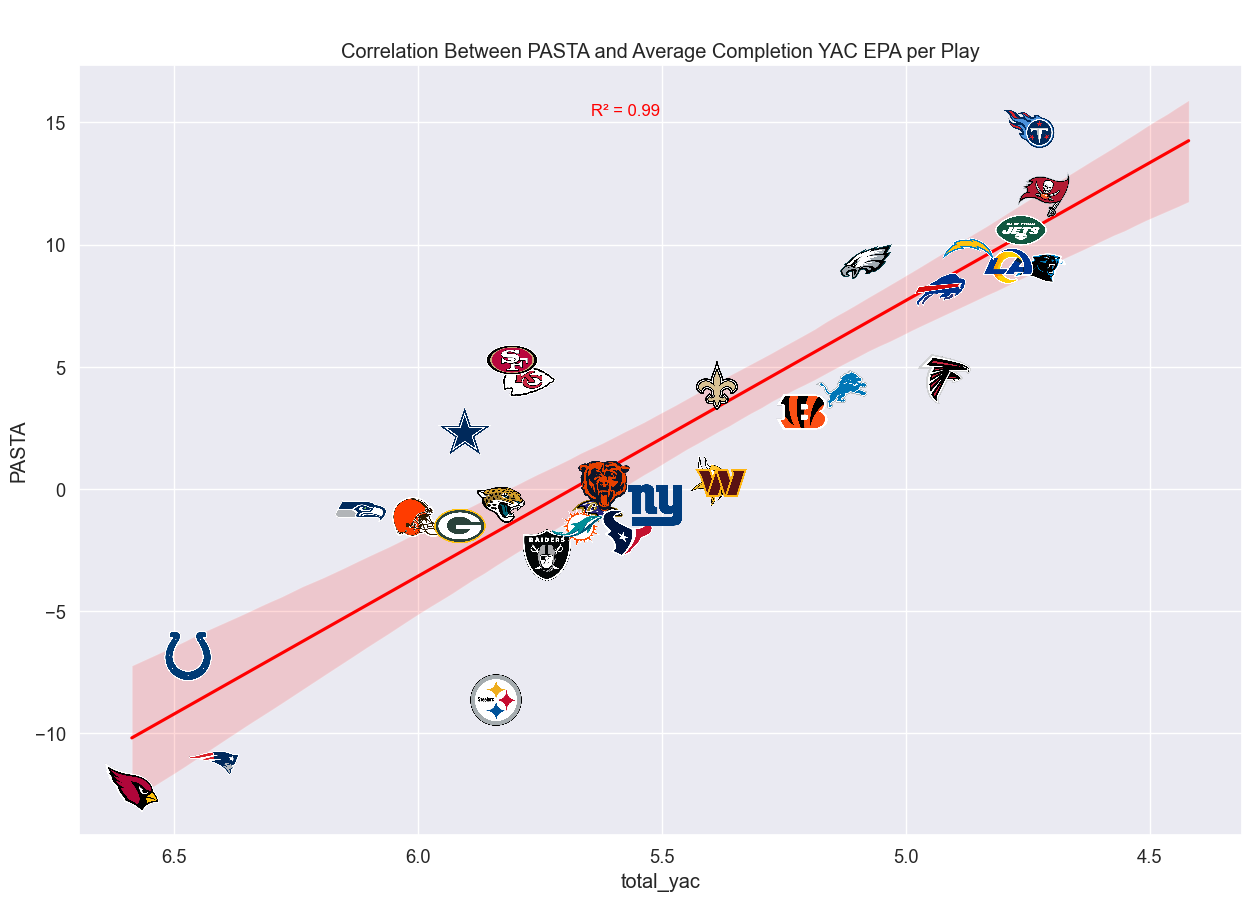

In [489]:
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Create the scatter plot with a regression line
fig, ax = plt.subplots(figsize=(15, 10))
sns.regplot(x='total_yac', y='pasta_index', data=playfrechet_team_df_with_colors, ax=ax, scatter=False, color='red')

# Invert X and Y axes
ax.invert_xaxis()  # This will show lower yac epa on the top



# Plot each team with its logo
for index, row in playfrechet_team_df_with_colors.iterrows():
    # Load team logo from URL
    response = requests.get(row['team_logo_espn'])
    img = Image.open(BytesIO(response.content))

    # Convert image to a format suitable for matplotlib
    imagebox = OffsetImage(img, zoom=0.08)
    ab = AnnotationBbox(imagebox, (row['total_yac'], row['pasta_index']), frameon=False)
    ax.add_artist(ab)

# Set labels and title
ax.set_xlabel('total_yac')
ax.set_ylabel('PASTA')
ax.set_title('Correlation Between PASTA and Average Completion YAC EPA per Play')
ax.text(0.5, 0.95, f'R\u00b2 = {r_value**2:.2f}', ha='right', va='top', transform=ax.transAxes, color='red', fontsize=12)

plt.show()


In [490]:
player_totals_scores

,nflId,displayName,position,defensiveTeam,total_frechet,average_frechet,average_yac_diff,total_yac_diff,average_yac,total_yac,...,team_color,team_color2,team_color3,team_color4,team_logo_wikipedia,team_logo_espn,team_wordmark,team_conference_logo,team_league_logo,PASTA RANK
0,54632.0,Daron Bland,CB,DAL,205.4,5.7,2.1,72.500000,4.8,4.8,...,#002244,#B0B7BC,#acc0c6,#a5acaf,https://upload.wikimedia.org/wikipedia/commons...,https://a.espncdn.com/i/teamlogos/nfl/500/dal.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,1.0
1,52472.0,Jeremy Chinn,FS,CAR,501.4,6.0,2.0,154.100006,3.3,3.3,...,#0085CA,#000000,#bfc0bf,#0085ca,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500-dark...,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,2.0
2,43387.0,Justin Simmons,FS,DEN,773.7,6.5,1.9,211.300003,4.5,4.5,...,#002244,#FB4F14,#00234c,#ff5200,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/den.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,3.0
3,40031.0,Logan Ryan,FS,TB,436.2,5.3,1.5,114.099998,3.7,3.7,...,#A71930,#322F2B,#000000,#ff7900,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/tb.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,4.0
4,46775.0,J.C. Jackson,CB,LAC,514.1,6.5,1.7,132.100006,4.2,4.2,...,#007BC7,#ffc20e,#ffb612,#001532,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/lac.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,44837.0,Jabrill Peppers,SS,NE,515.4,8.2,-1.4,-85.300003,7.1,7.1,...,#002244,#C60C30,#b0b7bc,#001532,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/ne.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,238.0
238,54584.0,Jalyn Armour-Davis,CB,BAL,267.0,9.9,-1.9,-50.200001,7.3,7.3,...,#241773,#9E7C0C,#9e7c0c,#c60c30,https://upload.wikimedia.org/wikipedia/en/thum...,https://a.espncdn.com/i/teamlogos/nfl/500/bal.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,239.0
239,52697.0,James Pierre,CB,PIT,398.7,8.5,-1.9,-88.099998,7.0,7.0,...,#000000,#FFB612,#c60c30,#00539b,https://upload.wikimedia.org/wikipedia/commons...,https://a.espncdn.com/i/teamlogos/nfl/500/pit.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,240.0
240,46729.0,Brandon Facyson,CB,IND,599.0,8.7,-2.0,-134.399994,8.0,8.0,...,#002C5F,#a5acaf,#013369,#9ba1a2,https://upload.wikimedia.org/wikipedia/commons...,https://a.espncdn.com/i/teamlogos/nfl/500/ind.png,https://github.com/nflverse/nflfastR-data/raw/...,https://github.com/nflverse/nflfastR-data/raw/...,https://raw.githubusercontent.com/nflverse/nfl...,241.0


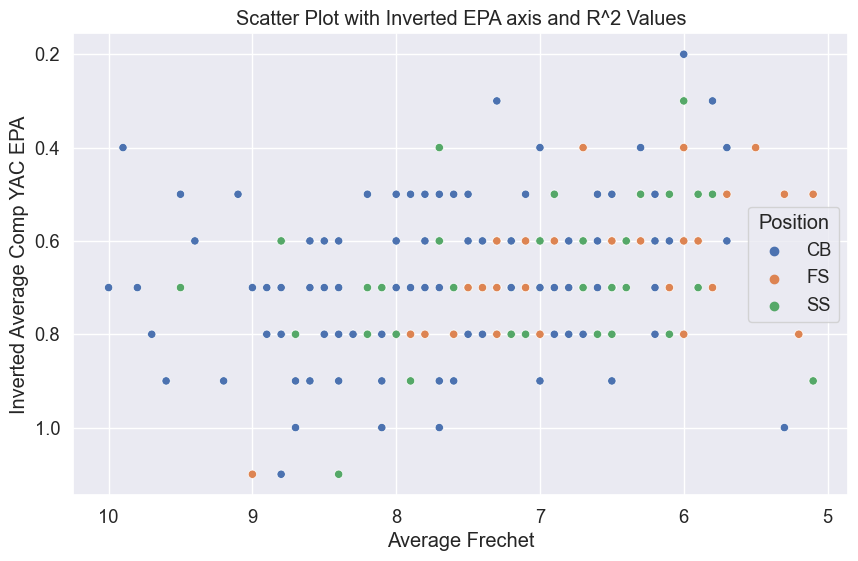

{'CB': -49.69504022732306, 'FS': -50.755226547256825, 'SS': -51.7464816090074, 'All': -42.93289819624393}


In [494]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for plotting
from sklearn.metrics import r2_score

# Assuming player_totals_scores is your DataFrame and has the required columns.

# Calculate R^2 values
r2_values = {}
positions = player_totals_scores['position'].unique()
for position in positions:
    subset = player_totals_scores[player_totals_scores['position'] == position]
    r2_values[position] = r2_score(subset['average_frechet'], subset['average_comp_yac_epa'])

# R^2 for all positions
r2_values['All'] = r2_score(player_totals_scores['average_frechet'], player_totals_scores['average_comp_yac_epa'])

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(data=player_totals_scores, x='average_frechet', y='average_comp_yac_epa', hue='position')

plt.xlabel('Average Frechet')
plt.ylabel('Inverted Average Comp YAC EPA')  # Update this label to reflect the correct metric
plt.title('Scatter Plot with Inverted EPA axis and R^2 Values')
plt.legend(title='Position')
plt.gca().invert_yaxis()  # Invert the y-axis
plt.gca().invert_xaxis()  # Invert the y-axis

plt.grid(True)
plt.show()

# Print R^2 values
print(r2_values)




In [495]:
import pandas as pd

# Assuming your DataFrame is named completed_passes

# Group by game and play, then sum 'frechet_distance' and take 'yac_diff' for each play
aggregated_df = completed_passes.groupby(['game_id', 'play_id', 'defensiveTeam']).agg({'frechet_distance':'sum', 'yac_diff':'mean'}).reset_index()


NameError: name 'completed_passes' is not defined

In [ ]:
# Count the number of unique 'nflId' per play
player_count = completed_passes.groupby(['game_id', 'play_id'])['nflId'].nunique().reset_index(name='player_count')

# Merge this count with the aggregated_df
merged_df = pd.merge(aggregated_df, player_count, on=['game_id', 'play_id'], how='left')

# Calculate per-player frechet_distance statistics
merged_df['frechet_per_player'] = merged_df['frechet_distance'] / merged_df['player_count']


In [ ]:
merged_df.info()

In [ ]:
merged_df = merged_df.merge(colors_data, left_on = 'defensiveTeam', right_on= 'team_abbr', how='left')

In [ ]:
merged_df.columns

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot for frechet_distance per player vs. yac_diff
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='frechet_distance', y='yac_diff')
plt.title('Correlation between YAC Difference Per Play and Frechet Distance Per Play')
plt.xlabel('Frechet Distance Per Play')
plt.ylabel('YAC Difference Expected - Actual Per Play')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the DataFrame for yac_diff below the threshold of 3
filtered_df = merged_df[merged_df['yac_diff'] > -20]

# Calculate the correlation
correlation = filtered_df['frechet_per_player'].corr(filtered_df['yac_diff'])

# Scatter plot for yac_diff vs. frechet_distance per player with the filtered data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_df, x='yac_diff', y='frechet_per_player')

# Adding the correlation coefficient to the plot
plt.title(f'Correlation between Per-Player Involved in Tackle Frechet Distance and YAC Difference (YAC Diff < 3)\nCorrelation: {correlation:.2f}')
plt.xlabel('YAC Difference')
plt.ylabel('Frechet Distance Per Player Involved in Tackle')

plt.show()




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'merged_data' is your merged dataset




# Step 3: Assess the correlation
correlation = completed_passes[['yac_diff', 'play_frechet']].corr().iloc[0, 1]
print(f"Correlation between YAC difference and Frechet distance: {correlation:.3f}")

# Step 4: Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=completed_passes, x='yac_diff', y='play_frechet')
plt.title('Scatter Plot of YAC Difference vs. Frechet Distance')
plt.xlabel('Difference in YAC (Actual - Expected)')
plt.ylabel('Frechet Distance')
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming 'merged_data' is your merged dataset

# Step 1: Filter for completed passes
completed_passes = merged_data[merged_data['passResult'] == 'C']

# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
completed_passes['yac_diff'] = completed_passes['yards_after_catch'] - completed_passes['xyac_mean_yardage']

# Step 3: Define a threshold for low unexpected YAC and filter
# Let's say we define "significantly lower" as at least 3 yards less than expected
threshold = 3
low_unexpected_yac = completed_passes[completed_passes['yac_diff'] <= threshold]

# Step 4: Assess the correlation in this subset
correlation = low_unexpected_yac[['yac_diff', 'play_frechet']].corr().iloc[0, 1]
print(f"Correlation in low unexpected YAC subset: {correlation:.3f}")

# Step 5: Create a scatter plot for this subset
plt.figure(figsize=(10, 6))
sns.scatterplot(data=low_unexpected_yac, x='yac_diff', y='play_frechet')
plt.title('Scatter Plot of YAC Difference vs. Frechet Distance in Low Unexpected YAC Subset')
plt.xlabel('Difference in YAC (Actual - Expected)')
plt.ylabel('Frechet Distance')
plt.show()


In [ ]:
merged_data.columns

In [ ]:
merged_data
# Step 2: Calculate the difference between yards_after_catch and xyac_mean_yardage
merged_data['yac_diff'] = merged_data['yards_after_catch'] - merged_data['xyac_mean_yardage']

In [13]:
test_df = pd.read_csv('/Users/nick/nfl-big-data-bowl-2024/data/specific_plays_paths.csv')

In [16]:
# Assuming test_df is your DataFrame
print("Number of unique Play IDs:", test_df['playId'].nunique())
print("Number of unique Games:", test_df['game_id'].nunique())


Number of unique Play IDs: 21


KeyError: 'game_id'

In [ ]:
# Group by 'playId' and count unique 'nflId's in each group
unique_nfl_ids_per_play = test_df.groupby('playId')['nflId'].nunique()

# Calculate the average number of unique 'nflId's per play
average_nfl_ids_per_play = unique_nfl_ids_per_play.mean()

print("Average number of unique NFL IDs per play:", average_nfl_ids_per_play)


In [ ]:
# Group by 'playId' and count unique 'frameId's in each group
unique_frames_per_play = test_df.groupby('playId')['frameId'].nunique()

# Calculate the average number of unique frames per play
average_frames_per_play = unique_frames_per_play.mean()

print("Average number of unique frames per play:", average_frames_per_play)



In [17]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2561 entries, 0 to 2560
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   nflId     2561 non-null   float64
 1   gameId    2561 non-null   int64  
 2   playId    2561 non-null   float64
 3   frameId   2561 non-null   int64  
 4   actual_x  2561 non-null   float64
 5   actual_y  2561 non-null   float64
 6   smooth_x  2561 non-null   float64
 7   smooth_y  2561 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 160.2 KB
